<img src="../images/ibm-logo-bw.png" alt="ibm-logo-bw" align="center" style="width: 200px;"/>

**AI ENTERPRISE WORKFLOW CERTIFICATION**

<hr />

### Case Study - Data visualization Solution


## Objectives

Recall that you are trying to identify the factors that contribute to the unique market situation in Singapore. Singapore has a higher rate of churn than the other markets and there is something in the data that, once uncovered, will allow you to make a hypothesis.

Your deliverable is a storyboard. The story should begin with descriptions of the data along with a summary of the business opportunity. The rest of the story details the process of your investigation and puts into context your findings. Finally, you should end with some discussion and suggestions about next steps in the process.

 ### Data Ingestion

* Let's consider a data ingestion script that readily accepts more data in batch form
* We will be using the AAVAIL datasets as a basis for this case study.
* Let's start by gathering data from the sources provided.

We will be working on necessary data given below:

* [m2-u4-case-study.ipynb](m1-u6-case-study.ipynb)
* [aavail-customers.db](./data/aavail-customers.db)
* [aavail-steams.csv](./data/aavail-streams.csv)

In [4]:
## all the imports you will need for this case study
import os
import pandas as pd
import numpy as np
import sqlite3

## specify the directory you saved the data in
data_dir = os.path.join(".","data")

Let's connect to this using the sqlite3 Python package with the function shown below.

In [5]:
def connect_db(file_path):
    try:
        conn = sqlite3.connect(file_path)
        print("...successfully connected to db\n")
    except Error as e:
        print("...unsuccessful connection\n",e)
    
    return(conn)

Let's make the connection to the database and see the table names 

In [7]:
## make the connection to the database
conn = connect_db(os.path.join(data_dir,"aavail-customers.db"))

## print the table names
tables = [t[0] for t in conn.execute("SELECT name FROM sqlite_master WHERE type='table';")]
print(tables)

...successfully connected to db

['CUSTOMER', 'INVOICE', 'INVOICE_ITEM', 'COUNTRY']


* Now that we have extracted the relevant data from the DB, let's query the database and extract the following data into a Pandas DataFrame.

      - Customer ID (integer)
      - Last name
      - First name
      - DOB
      - City
      - State
      - Country
      - Gender

* SQL is case-insensitive, but it is traditional to use ALL CAPS for SQL keywords.

In [8]:
query = """
SELECT cu.customer_id, cu.last_name, cu.first_name, cu.DOB,
       cu.city, cu.state, co.country_name, cu.gender
FROM CUSTOMER cu
INNER JOIN COUNTRY co
ON cu.country_id = co.country_id;
"""

_data = [d for d in conn.execute(query)]
columns = ["customer_id","last_name","first_name","DOB","city","state","country","gender"]
df_db = pd.DataFrame(_data,columns=columns)
df_db.head()

,customer_id,last_name,first_name,DOB,city,state,country,gender
0,1,Todd,Kasen,07/30/98,Rock Hill,South Carolina,united_states,m
1,2,Garza,Ensley,04/12/89,singapore,None,singapore,f
2,3,Carey,Lillian,09/12/97,Auburn,Alabama,united_states,f
3,4,Christensen,Beau,01/28/99,Hempstead,New York,united_states,m
4,5,Gibson,Ernesto,03/23/98,singapore,None,singapore,m


* Now that we have the data from AAVAIL db, our next steps will be to extract the relevant data from the CSV file.

* For each customer_id we have to check if a customer has stopped their subscription or not and save it in a dictionary or another data container.

In [9]:
df_streams = pd.read_csv(os.path.join(data_dir,r"aavail-streams.csv"))
df_streams.head()

,customer_id,stream_id,date,invoice_item_id,subscription_stopped
0,1,1420.0,2018-10-21,2.0,0
1,1,1343.0,2018-10-23,2.0,0
2,1,1756.0,2018-11-05,2.0,0
3,1,1250.0,2018-11-06,2.0,0
4,1,1324.0,2018-11-12,2.0,0


In [10]:
customer_ids = df_streams['customer_id'].values
unique_ids = np.unique(df_streams['customer_id'].values)
streams = df_streams['subscription_stopped'].values
has_churned = [0 if streams[customer_ids==uid].max() > 0 else 1 for uid in unique_ids]
df_churn = pd.DataFrame({"customer_id": unique_ids,"is_subscriber": has_churned})
df_churn.head()

,customer_id,is_subscriber
0,1,1
1,2,0
2,3,0
3,4,1
4,5,1


#### Exploratory Data Analysis

Sometimes it is known in advance which types of data integrity issues to expect, but other times it is during the Exploratory Data Analysis (EDA) process that these issues are identified. 

After extracting data it is important to include checks for quality assurance even on the first pass through the AI workflow.  Let's combine the data into a single structure and provide a couple checks for quality assurance.

**Implementation of checks for Quality Assurance**

- Remove any repeat customers based on customer_id
- Remove stream data that do not have an associated stream_id
- Check for missing values

In [11]:
print("\nCleaning Summary\n{}".format("-"*35))
duplicate_rows = df_db.duplicated()
if True in duplicate_rows:
    df_db = df_db[~duplicate_rows]
print("Removed {} duplicate rows".format(np.where(duplicate_rows==True)[0].size))

missing_stream_ids = np.isnan(df_streams['stream_id'])    
if True in missing_stream_ids:
    df_streams = df_streams[~missing_stream_ids]
print("Removed {} missing stream ids".format(np.where(missing_stream_ids==True)[0].size))

print("\nMissing Value Summary\n{}".format("-"*35))
print("\ndf_db\n{}".format("-"*15))
print(df_db.isnull().sum(axis = 0))
print("\ndf_streams\n{}".format("-"*15))
print(df_streams.isnull().sum(axis = 0))


Cleaning Summary
-----------------------------------
Removed 7 duplicate rows
Removed 1164 missing stream ids

Missing Value Summary
-----------------------------------

df_db
---------------
customer_id      0
last_name        0
first_name       0
DOB              0
city             0
state          300
country          0
gender           0
dtype: int64

df_streams
---------------
customer_id             0
stream_id               0
date                    0
invoice_item_id         0
subscription_stopped    0
dtype: int64


**Combine the data into a single data structure**

The two most convenient structures for this task are Pandas dataframes and NumPy arrays. At a minimum ensure that your structure accommodates the following.

- A column for customer_id
- A column for country
- A column for age that is created from DOB
- A column customer_name that is created from first_name and last_name
- A column to indicate churn called is_subscriber
- A column that indicates subscriber_type that comes from invoice_item
- A column to indicate the total num_streams

In [16]:
import scipy.stats as stats

df_clean = df_churn.copy()
df_clean = df_clean[np.in1d(df_clean['customer_id'].values,df_db['customer_id'].values)]
unique_ids = df_clean['customer_id'].values

## ensure we are working with correctly ordered customer_ids df_db
if not np.array_equal(df_clean['customer_id'],df_db['customer_id']): 
    raise Exception("indexes are out of order or unmatched---needs to fix")

## query the db t create a invoice item map
query = """
SELECT i.invoice_item_id, i.invoice_item
FROM INVOICE_ITEM i;
"""

## variables for new df creation
invoice_item_map = {d[0]:d[1] for d in conn.execute(query)}
streams_stopped = df_streams['subscription_stopped'].values
streams_cid = df_streams['customer_id'].values
streams_iid = df_streams['invoice_item_id'].values
subscriber_invoice_mode = [stats.mode(streams_iid[streams_cid==uid])[0][0] for uid in unique_ids]

## create the new df
df_clean['country'] = df_db['country']
df_clean['age'] = np.datetime64('today') - pd.to_datetime(df_db['DOB'])
df_clean['customer_name'] = df_db['first_name'] + " " + df_db['last_name']
df_clean['subscriber_type'] = [invoice_item_map[int(sim)] for sim in subscriber_invoice_mode]
df_clean['num_streams'] = [streams_stopped[streams_cid==uid].size for uid in unique_ids]

## convert age to days
df_clean['age'] = [a.astype('timedelta64[Y]').astype(int) for a in df_clean['age'].values]

df_clean.head()

,customer_id,is_subscriber,country,age,customer_name,subscriber_type,num_streams
0,1,1,united_states,-29,Kasen Todd,aavail_premium,23
1,2,0,singapore,-20,Ensley Garza,aavail_unlimited,12
2,3,0,united_states,-28,Lillian Carey,aavail_premium,22
3,4,1,united_states,-30,Beau Christensen,aavail_basic,19
4,5,1,singapore,-29,Ernesto Gibson,aavail_premium,23


#### Investigative Visualization

Data visualization is the discipline of trying to understand data by placing it in a visual context so that patterns, trends and correlations that might not otherwise be detected can be exposed. The tables we just created above is difficult to navigate it can be useful to use a simple plot to summarize the data. It is possible that both a table and a plot might be needed to communicate the findings and one common practice is to include an appendix in the deliverable. 

Another related practice when it comes to EDA is that the communication of your findings, usually via deliverable, is done in a clean and polished way. If using a notebook as a communication tool take the time to remove unnecessary code blocks and other elements as they can distract from the principal takeaways.

The goal here is to see what factors are influencing the Singapore situation and let's start by analyzing these factors.

In [20]:
#import Data Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [37]:
print(pd.crosstab(df_clean.is_subscriber, df_clean.country))

country        singapore  united_states
is_subscriber                          
0                    181            108
1                    119            592


The values above show that there are 181 non-subscribers in the Singapore and 108 in US and there are 119 subscribers in Singapore and 592 in US. We can understand that there are more subscribers in the US than in Singapore.

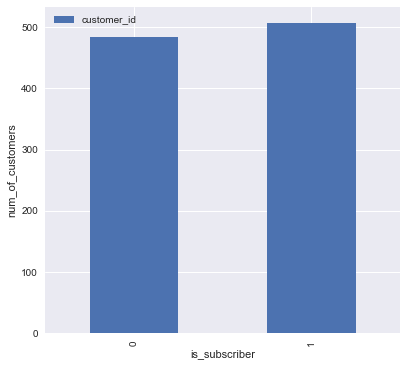

In [122]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

table_c = pd.pivot_table(df_clean, index = ['is_subscriber'], values = 'customer_id')
table_c.plot(kind='bar',ax=ax1)
ax1.set_xlabel("is_subscriber");
ax1.set_ylabel("num_of_customers");

The analysis above shows the number of subscribed customers are > 500 and more and non subscribers are < 500. This alone would not give us more insight into the subscribers so let's perform some deep data analysis further.  

In [1]:
pd.melt(df_clean, id_vars=['is_subscriber'], value_vars=["country"], var_name='country' )

NameError: name 'pd' is not defined

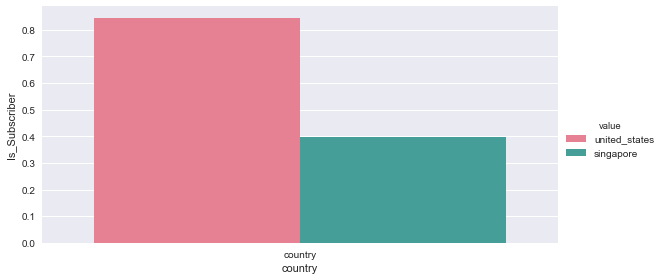

In [92]:
# Create a new temporary dataframe to help us plot these variables.
df1 = pd.melt(df_clean, id_vars=['is_subscriber'], value_vars=["country"], var_name='country' )

# Create a factorplot
g = sns.factorplot( x="country", y="is_subscriber", hue='value', data=df1, size=4, aspect=2, kind="bar", palette="husl", ci=None )
g.despine(left=True)
g.set_ylabels("Is_Subscriber")
plt.show()

Most features have a wider range of numbers, not just 0 or 1. So for those it makes sense to look at how the distribution of the data differs for the people that are non-subscribers and the people that are subscribers. Let's add more dimensions in the data and see how what exactly is the state of Singapore.

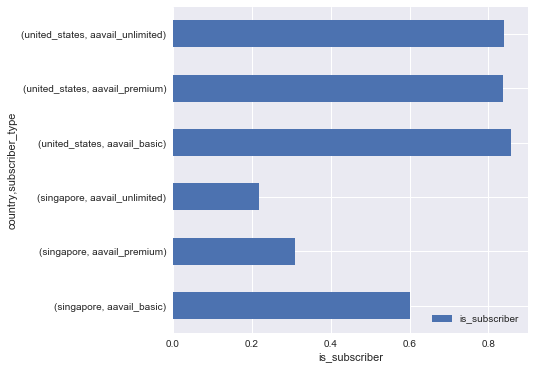

In [115]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

table1 = pd.pivot_table(df_clean, index = ['country', 'subscriber_type'], values = 'is_subscriber')
table1.plot(kind='barh',ax=ax1)
ax1.set_xlabel("is_subscriber");

From the analysis above we can see that the number of unlimited subscribers in Singapore is really low compared to premium subscribers and basic. We can understand this pattern that the basic subscribers in Singapore are more prone to churn out soon. 

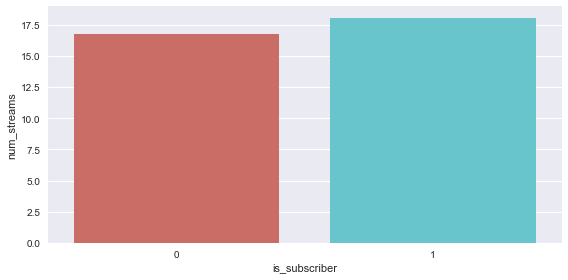

In [100]:
# Create a factorplot
j = sns.factorplot( x="is_subscriber", y="num_streams", data=df_clean, size=4, aspect=2, kind="bar", palette= "hls", ci=None )
j.despine(left=True)
j.set_ylabels("num_streams")
plt.show()

The above analysis explains the num_streams distribution among subscribers and non-subscribers, however this information is not enough and we will need to create an age distribution for different countries. Let's analyze num_streams distribution for different countries.

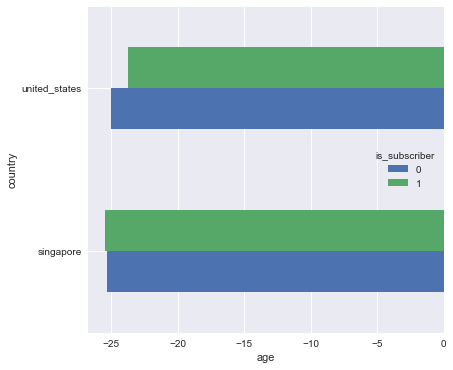

In [90]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
table3 = df_clean.pivot_table('age', index='country', columns='is_subscriber')
table3.plot(kind='barh',ax=ax1)
ax1.set_xlabel("age");

The analysis above shows that the average age of both subscribers and non-subscribers is almost 25 years of age in Singapore. This gives us an important insight to analyze the avergae age for each subscriber_type.

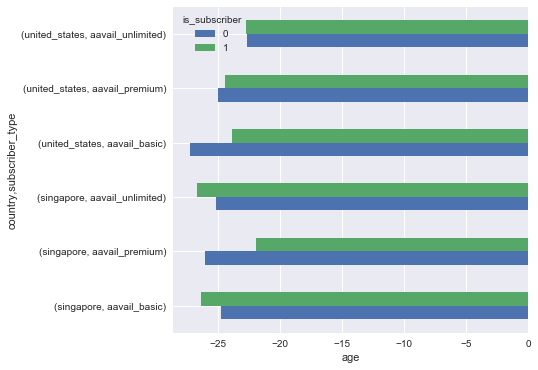

In [89]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
table4 = df_clean.pivot_table('age', index=['country','subscriber_type'], columns='is_subscriber')
table4.plot(kind='barh',ax=ax1)
ax1.set_xlabel("age");

So now that we have the analysis for country and subscriber_type vs age and we can see that average age for a subscriber of basic subscribers is more than 25 and for premium subscribers the average age is approximately 22. For unlimited subscribers the average age is more than 25 in Singapore. From this analysis we can infer that the average age for basic subscribers and unlimited subscribers in Singapore < = 25.

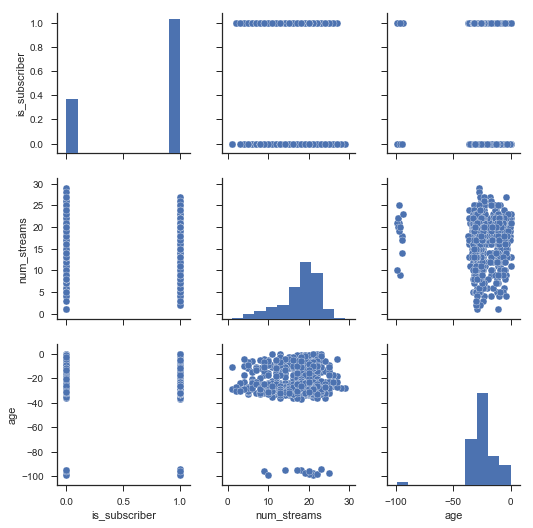

In [125]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

## make a pair plot
columns = ['is_subscriber', 'num_streams', 'age']

axes = sns.pairplot(df_clean, vars=columns, palette="husl")

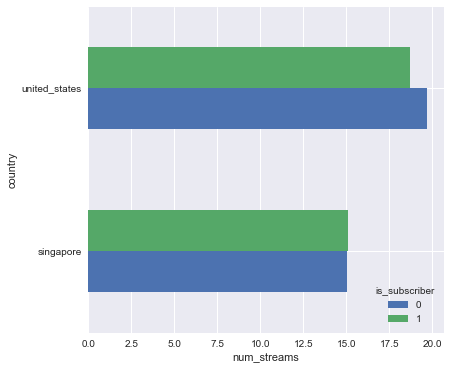

In [81]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
table2 = df_clean.pivot_table('num_streams', index='country', columns='is_subscriber')
table2.plot(kind='barh',ax=ax1)
ax1.set_xlabel("num_streams");

The analysis above shows that both the subscribers and non-subscribers have approximately 15.0 number of streams in Singapore and probably is not an important feature but we need to perform more data analysis to prove the hypothesis.

### Findings from the analysis of our Features

**As we undertsand that the goal of our data analysis was to find factors that are influencing the Singapore situation**

Here are some of the findings of the data analysis:

- There are more subscribers in the US than in Singapore.
- the number of unlimited subscribers in Singapore is really low compared to premium subscribers and basic
- The basic subscribers in Singapore is more prone to churn out soon compared to premium and unlimited.
- Both the subscribers and non-subscribers have approximately 15.0 number of streams in Singapore.
- The average age of both subscribers and non-subscribers is almost 25 years of age in Singapore
- The average age for basic subscribers and unlimited subscribers in Singapore < = 25.
    

### Next Steps

From the findings abover we understand some of the important factors influencing our goal to be the subscriber_type, age and location but 
our findings does not provide any specific or deep insights on the factors that influence our goal.

Some of the next steps that can be performed are:
* Deep Dive Data analysis on each feature - We can use PCA (Principal Component Analysis) to explore the variations in variables.
* Hypothesis testing  - We can hypothesize each feature and it's importance.
* We can also calculate multiple types of aggregations for any given feature for better data explorations.